---
#### Train
---

In [1]:
import pandas as pd
import os
import numpy as np
import time
import pickle
import warnings
from datetime import datetime
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Dense, LSTM, BatchNormalization, Dropout, Conv1D, GlobalMaxPool1D, SimpleRNN
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

Using TensorFlow backend.


---
#### 일단 네이블 통해 받은 데이터로 훈련을 한다.
---

In [2]:
ct = pd.read_csv('training-data-Slice03-20200118.csv')

In [3]:
ct

,SLICE,DATETIME,UPLINK_THROUGHPUT,DNLINK_THROUGHPUT,ACTIVE_USER
0,Slice03,2020-01-18T00:00:00,7196346,145528982,1254
1,Slice03,2020-01-18T00:05:00,5388918,82593121,1227
2,Slice03,2020-01-18T00:10:00,5135765,99928607,1275
3,Slice03,2020-01-18T00:15:00,5405083,72853040,1392
4,Slice03,2020-01-18T00:20:00,4363877,85285010,1275
...,...,...,...,...,...
687,Slice03,2020-01-20T09:40:00,11763722,158518799,2369
688,Slice03,2020-01-20T09:45:00,12594923,218630767,2363
689,Slice03,2020-01-20T09:50:00,12516225,171208314,2441
690,Slice03,2020-01-20T09:55:00,19486155,157620601,2354


In [4]:
import numpy as np
def create_dataset(signal_data, look_back = 144):
    dataX, dataY = [], []
    for i in range(len(signal_data)-156):
        dataX.append(signal_data[i:(i+look_back), 0])
        dataY.append(signal_data[(i + look_back):(i+156), 0])
    return np.array(dataX), np.array(dataY)

look_back = 144 ## 하루. 

train = ct[['DNLINK_THROUGHPUT']].values.reshape(-1,1)
x_train, y_train = create_dataset(train, look_back)

x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

model = Sequential()
model.add(SimpleRNN(144, return_sequences= True))
model.add(BatchNormalization())
model.add(SimpleRNN(144))
model.add(Dense(12, activation = 'linear'))
model.compile(loss='mean_squared_error', optimizer='adam')

# earlyStopping = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min')
# mcp_save = ModelCheckpoint('/data01/CSB/CSB_Jupyter/PROBE/Pyfile/CSB-Modelling/10월16일/TANGO/best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

hist = model.fit(x_train/1e8, y_train/1e8, epochs=10, batch_size = 2)

Epoch 1/10
536/536 [==============================] - 49s 91ms/step - loss: 0.9726
Epoch 2/10
536/536 [==============================] - 45s 83ms/step - loss: 0.2900
Epoch 3/10
536/536 [==============================] - 41s 77ms/step - loss: 0.4384
Epoch 4/10
536/536 [==============================] - 40s 74ms/step - loss: 0.3179
Epoch 5/10
536/536 [==============================] - 40s 75ms/step - loss: 0.2888
Epoch 6/10
536/536 [==============================] - 40s 74ms/step - loss: 0.2913
Epoch 7/10
536/536 [==============================] - 40s 75ms/step - loss: 0.3043
Epoch 8/10
536/536 [==============================] - 40s 75ms/step - loss: 0.3039
Epoch 9/10
536/536 [==============================] - 40s 75ms/step - loss: 0.3090
Epoch 10/10
536/536 [==============================] - 40s 75ms/step - loss: 0.2872


#### model 저장

In [18]:
model.save('Slice03-prediction-downlink-throughput.h5')

---
## 모델 제대로 돌아가는지 test 용
---

In [6]:
ct[['DNLINK_THROUGHPUT']][-144:]

,DNLINK_THROUGHPUT
140,223440683
141,293464169
142,194459740
143,211394321
144,182648297
...,...
279,184697574
280,166103144
281,183592710
282,192581044


In [13]:
prediction = ct[['DNLINK_THROUGHPUT']][0:144].values
    
    
result = model.predict(np.reshape(prediction,(1,144,1))/1e8)*1e8

In [10]:
result

array([[2.0125846e+08, 1.5854066e+08, 1.7630995e+08, 1.8327397e+08,
        1.6475536e+08, 2.4206350e+08, 2.3430514e+08, 2.5600154e+08,
        3.2973174e+08, 3.3308211e+08, 2.0041442e+08, 2.6337922e+08]],
      dtype=float32)

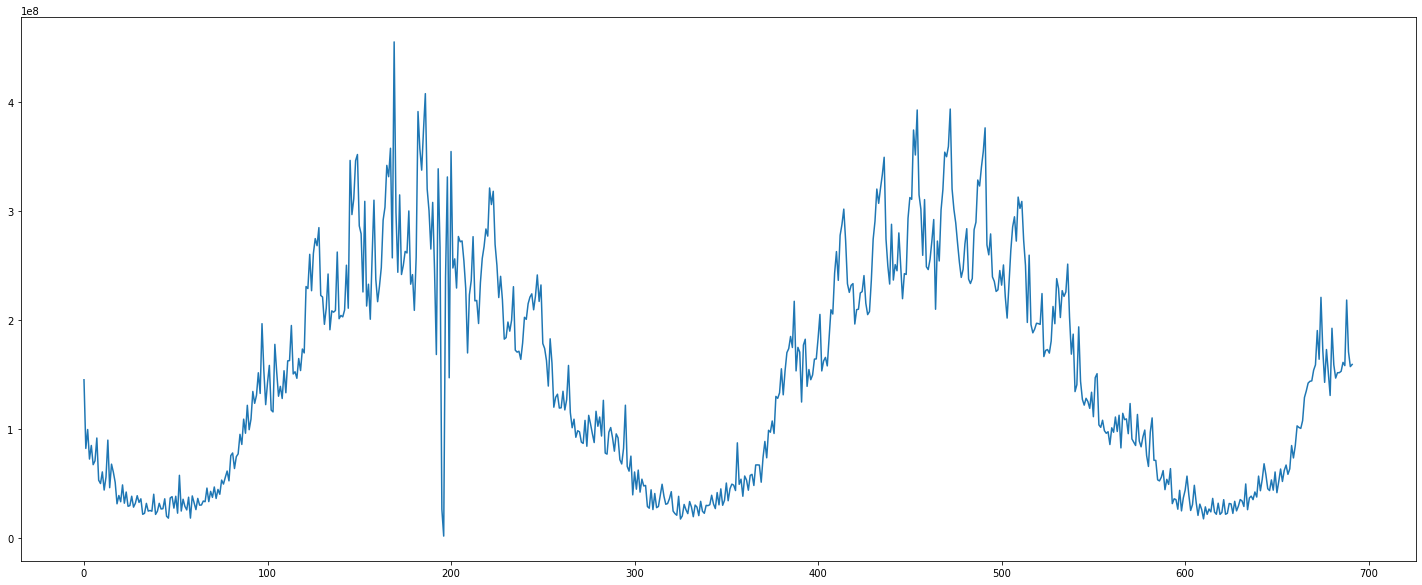

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))
plt.plot(ct[['DNLINK_THROUGHPUT']])
plt.show()

In [13]:
ct[['DNLINK_THROUGHPUT']]

,DNLINK_THROUGHPUT
0,168221782
1,181769954
2,200049739
3,213688407
4,163862849
...,...
279,184697574
280,166103144
281,183592710
282,192581044


In [15]:
test = pd.DataFrame(result[0])
test.columns =['DNLINK_THROUGHPUT']

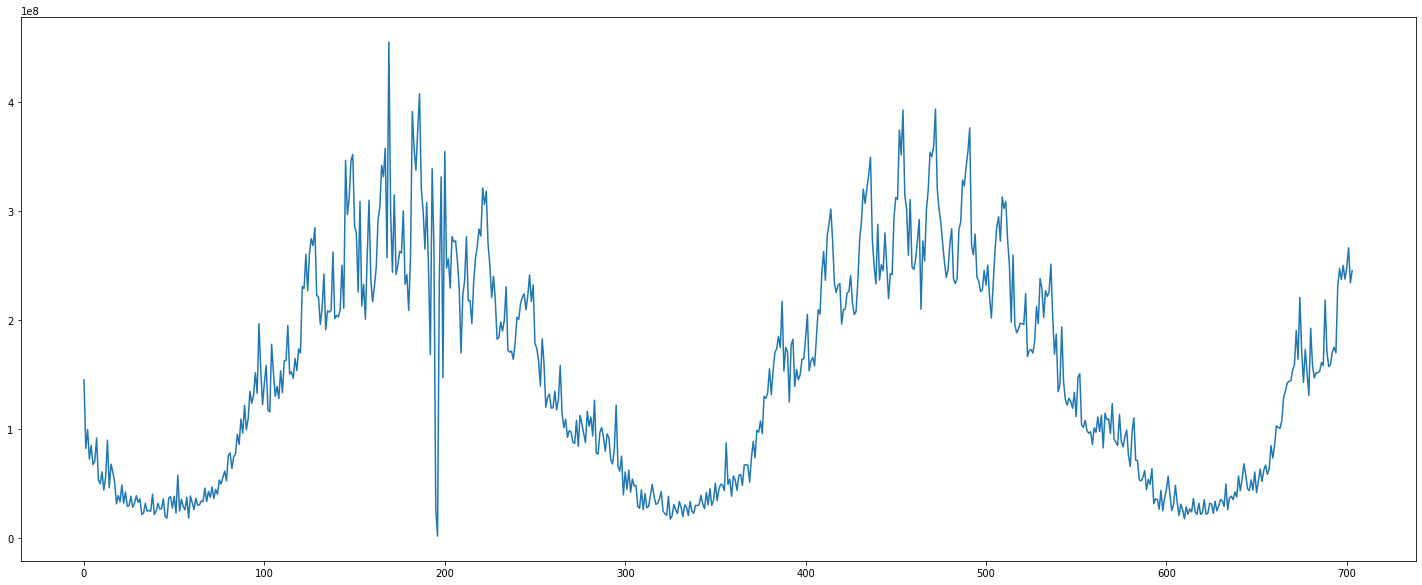

In [17]:
import matplotlib.pyplot as plt
plt.figure(figsize=(25,10))
plt.plot(pd.concat([ct[['DNLINK_THROUGHPUT']],test]).reset_index(drop=True))
plt.show()

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(result[0])
